# Chemprot Shortcut analysis

In [1]:
s3_test_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_test.json"
s3_train_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_train.json"
s3_val_prediction = "s3://aegovan-data/chemprot/predictions_chemprot-bert-f1-2022-05-22-23-18-21-560/prediction_chemprot_dev.json"

In [2]:
import sys, pandas as pd, os, matplotlib.pyplot as plt, sklearn
from sklearn import tree

sys.path.append("../src")


label_names = ["NEGATIVE",
                            "CPR:3",
                            "CPR:4",
                            "CPR:5",
                            "CPR:6",
                            "CPR:9"]

all_labels = list(range(len(label_names)))
pos_labels = list(range(1, len(label_names)))

trigger_words =  ["induced", "activator","upregulator" , "inhibitor","downregulator" , "agonist", "kinase","regulator","modulator"]



In [3]:
import sys, os, pandas as pd
sys.path.append("../src")

from utils.s3_utils import download_file as download_s3_file

## Download prediction

In [4]:
local_temp= "temp"

In [5]:
local_prediction_dir = os.path.join(local_temp, "prediction")
os.makedirs(local_prediction_dir, exist_ok=True)
local_test_prediction_file  = download_s3_file( s3_test_prediction, local_prediction_dir)
local_train_prediction_file  = download_s3_file( s3_train_prediction, local_prediction_dir)
local_val_prediction_file  = download_s3_file( s3_val_prediction, local_prediction_dir)




## Utils

In [6]:


def load_valtest_pred(file, labels_order = label_names):
    df = pd.read_json(file, orient="records")
    df["y"] = df["prediction"].apply(lambda x: labels_order.index(x))
    df["y_raw"] = df["prediction"]


    df["x"] = df["sentence_anonymised"].apply(lambda x: x.replace("_GENE-Y_", "_GENE_")
                                                                .replace("_GENE-N_", "_GENE_"))
    df["gold"] = df["label"].apply(lambda x: labels_order.index(x))
    df["gold_raw"] = df["label"]


    #df = df.query("is_eval == 'Y'").copy()

    return df

In [7]:
from model_nb_classifier import ModelNBClassifier
from model_nb_tree_relation_classifier import ModelNBTreeRelationClassifier



def train_and_predict(df, min_df=None):
    m = ModelNBTreeRelationClassifier("_CHEMICAL_", "_GENE_", min_df=min_df, trigger_words=trigger_words)
    print(trigger_words)
    #m= ModelNBClassifier("_CHEMICAL_", "_GENE_")
    m.train(df["x"], df["y"])
    return m, m.predict(df["x"])[0]



In [8]:
def print_report(actual, pred, latex=True, labels=None):
    

    pos_f1 = sklearn.metrics.f1_score(actual, pred, labels=labels, average='micro',
                                  sample_weight=None, zero_division=0)
    all_f1 = sklearn.metrics.f1_score(actual, pred, average='micro', sample_weight=None, zero_division=0)
    print(sklearn.metrics.classification_report(actual,
                                            pred,
                                            output_dict=False,
                                            labels=labels,zero_division=0)
     )
    
    if latex:
        
        d = sklearn.metrics.classification_report(actual,
                                                pred,
                                                output_dict=True,
                                                labels=labels,zero_division=0)
        return pd.DataFrame(d).T

In [9]:
def plot_tree(m):
    _, ax = plt.subplots(1,1, figsize=(45,15))

    tree.plot_tree(m.tree_model, ax=ax, fontsize=10, feature_names=m.feature_names)

    plt.show()

In [10]:
def get_top_discrimintary_keywords(model, label_index ) :
    index_to_vocab = {i:v  for v,i in model.vocab.items()}

    return sorted( [ (index_to_vocab[i],p) for i,p in enumerate(model.nb_model.feature_log_prob_[label_index])], 
           reverse=True, key=lambda x: x[1])[:50]




In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


def consolidate_label_names(actual, pred, label_names):
    label_indices = list(set(actual).union(pred))
    return [label_names[i] for i in sorted(label_indices)]

def plot_confusionmatrix(y_true,y_pred):
    cm = confusion_matrix(y_true,y_pred)
    labels = consolidate_label_names( y_true,y_pred,label_names)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = labels)
    disp.plot(cmap="PuBu", xticks_rotation="vertical")

In [12]:
def filter_eval(df):
    return df[df["is_eval"].apply(lambda r: r == 'Y')].copy() 

## Train GT Train predictions

In [14]:
df_train = load_valtest_pred(local_train_prediction_file)


df_train["shortcut_pred"] = train_and_predict(df_train, min_df=1)[1]

t_d_eval = df_train.pipe(filter_eval)



print_report(t_d_eval["gold"],t_d_eval["shortcut_pred"])

['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(6414, 14)
(6414, 14)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.70      0.78      0.74       774
           2       0.93      0.73      0.82      2251
           3       0.86      0.81      0.83       170
           4       0.86      0.87      0.86       229
           5       0.92      0.74      0.82       727

    accuracy                           0.75      4151
   macro avg       0.71      0.65      0.68      4151
weighted avg       0.88      0.75      0.81      4151



,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,0.000000
1,0.697110,0.779070,0.735815,774.000000
2,0.926678,0.729898,0.816600,2251.000000
3,0.856250,0.805882,0.830303,170.000000
4,0.857759,0.868996,0.863341,229.000000
5,0.919795,0.741403,0.821021,727.000000
accuracy,0.751867,0.751867,0.751867,0.751867
macro avg,0.709599,0.654208,0.677847,4151.000000
weighted avg,0.875981,0.751867,0.805451,4151.000000


['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(6414, 14)
(6414, 14)


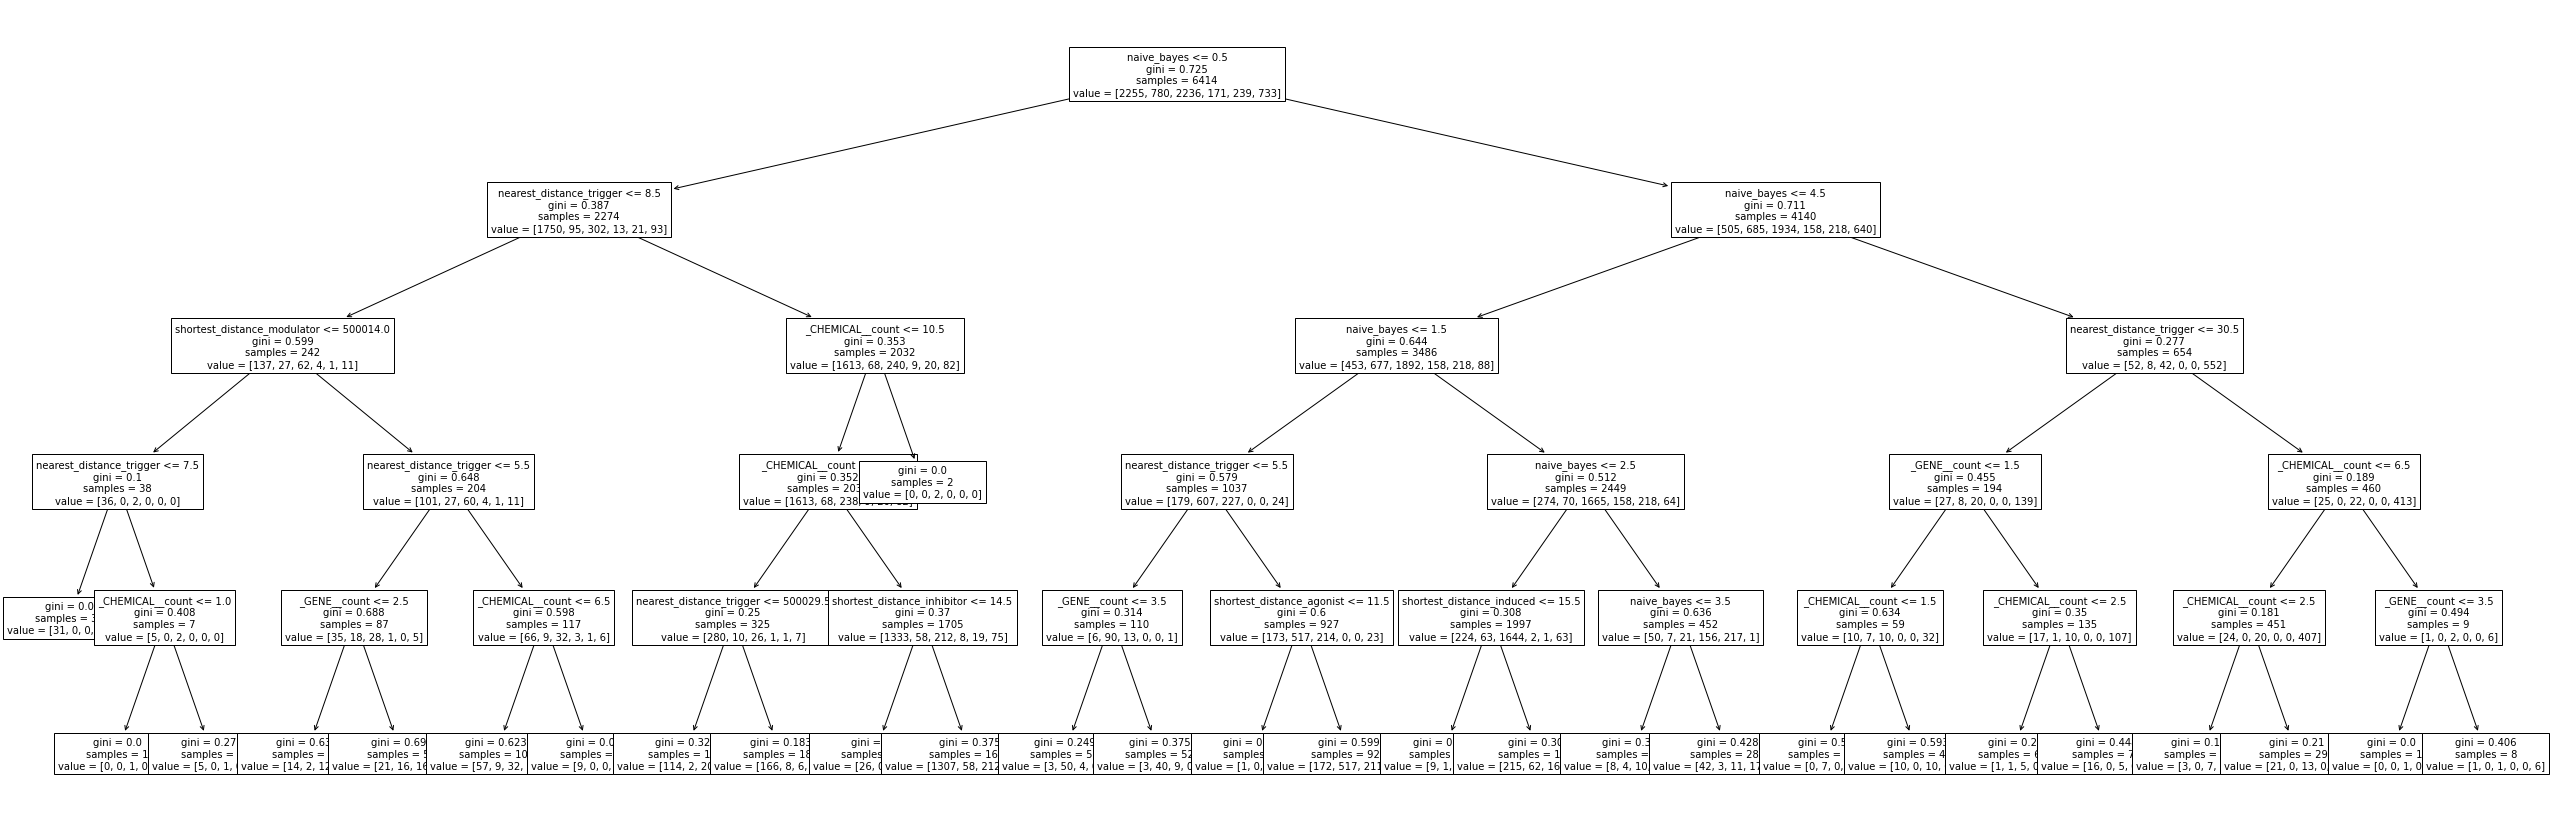

              precision    recall  f1-score   support

           1       0.70      0.79      0.74       774
           2       0.93      0.74      0.82      2234
           3       0.86      0.81      0.83       169
           4       0.86      0.87      0.87       229
           5       0.93      0.74      0.83       732

   micro avg       0.87      0.76      0.81      4138
   macro avg       0.86      0.79      0.82      4138
weighted avg       0.88      0.76      0.81      4138

              precision    recall  f1-score   support

           0       0.02      0.77      0.04        13
           1       0.70      0.79      0.74       774
           2       0.93      0.74      0.82      2234
           3       0.86      0.81      0.83       169
           4       0.86      0.87      0.87       229
           5       0.93      0.74      0.83       732

    accuracy                           0.76      4151
   macro avg       0.72      0.79      0.69      4151
weighted avg       0.88

In [15]:
df_train_prediction = load_valtest_pred(local_train_prediction_file)

t_m, df_train_prediction["shortcut_pred"] = train_and_predict(df_train_prediction, min_df=1)

plot_tree(t_m)

t_d_eval = df_train_prediction.pipe(filter_eval)

print_report(t_d_eval["y"], t_d_eval["shortcut_pred"], False, pos_labels)

print_report(t_d_eval["y"], t_d_eval["shortcut_pred"], False, all_labels)

## Val GT predictions


In [16]:
df_val = load_valtest_pred(local_val_prediction_file)


df_val["shortcut_pred"] = train_and_predict(df_val, min_df=1)[1]

t_d_eval = df_val.pipe(filter_eval)



print_report(t_d_eval["gold"],t_d_eval["shortcut_pred"])

['induced', 'activator', 'upregulator', 'inhibitor', 'downregulator', 'agonist', 'kinase', 'regulator', 'modulator']
(6414, 14)
(6414, 14)


ValueError: Length of values (6414) does not match length of index (3550)

In [ ]:
df_val_prediction = load_valtest_pred(local_val_prediction_file)

t_m, df_val_prediction["shortcut_pred"] = train_and_predict(df_val_prediction, min_df=1)

plot_tree(t_m)

t_d_eval = df_val_prediction.pipe(filter_eval)

print_report(t_d_eval["y"], t_d_eval["shortcut_pred"], False, pos_labels)

print_report(t_d_eval["y"], t_d_eval["shortcut_pred"], False, all_labels)

## Test 

In [ ]:
df_test = load_valtest_pred(local_test_prediction_file)


print_report(df_test["gold"],df_test["y"])

### Predict Test on Test GT fit

In [ ]:
df_test = load_valtest_pred(local_test_prediction_file)


df_test["shortcut_pred"] = train_and_predict(df_test, min_df=1)[1]

t_d_eval = df_test.pipe(filter_eval)



print_report(t_d_eval["gold"],t_d_eval["shortcut_pred"])

### Predict Test on Test Prediction fit 

In [ ]:
df_test_prediction = load_valtest_pred(local_test_prediction_file)

t_m, df_test_prediction["shortcut_pred"] = train_and_predict(df_test_prediction, min_df=1)

plot_tree(t_m)

t_d_eval = df_test_prediction.pipe(filter_eval)

print_report(t_d_eval["y"], t_d_eval["shortcut_pred"], False, pos_labels)

print_report(t_d_eval["y"], t_d_eval["shortcut_pred"], False, all_labels)

In [ ]:
print_report(df_test_prediction.query("y != gold")["y"], df_test_prediction.query("y != gold")["shortcut_pred"], False, all_labels)

In [ ]:
print_report(df_test_prediction.query("y == gold")["y"], df_test_prediction.query("y == gold")["shortcut_pred"], False, all_labels)

In [ ]:
get_top_discrimintary_keywords(t_m, 0)

In [ ]:
pd.set_option('display.max_colwidth',None)
df_test_prediction.pipe(filter_eval).query("'NEGATIVE' == y_raw ").sample(n=10)\
[["sentence_anonymised", "y_raw", "gold_raw",  "gold", "y","shortcut_pred","relationship_type"]]

In [ ]:
plot_confusionmatrix(df_test_prediction["y"], df_test_prediction["shortcut_pred"])